(target-dj-fetching-data)=
# DataJoint pipeline: Fetching data as DataFrames

:::{important}
This guide assumes you have a [DataJoint pipeline deployed](target-dj-pipeline-deployment) with [data already ingested](target-dj-data-ingestion-processing).
:::

This guide builds upon the [Querying data](target-dj-querying-data) guide and provides further examples on fetching various kinds of data as `pandas.DataFrames` from the [Aeon DataJoint pipeline](target-aeon-dj-pipeline).

You can also run this notebook online at [`works.datajoint.com`](https://works.datajoint.com/) using the following credentials:
 - Username: aeondemo
 - Password: aeon_djworks 

To access it, go to the Notebook tab at the top and in the File Browser on the left, navigate to `ucl-swc_aeon > docs > examples`, where this notebook `dj_fetching_data.ipynb` is located.

:::{note}
The examples here use the _social_ period of the [social0.2-aeon4](target-full-datasets) dataset.
Since the social period spans 2 weeks, we limit retrieval to the first 3 days to keep the examples concise.

If you are using a different dataset, be sure to replace the experiment name and parameters in the code below accordingly.
:::

## Import libraries and define variables and helper functions

In [59]:
from datetime import datetime
import warnings

import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from aeon.dj_pipeline import acquisition, streams, subject, tracking
from aeon.dj_pipeline.analysis.block_analysis import (
    Block,
    BlockAnalysis,
    BlockSubjectAnalysis,
    BlockForaging
)

In [2]:
def ensure_ts_arr_datetime(array):
    """Ensure array is a numpy array of datetime64[ns] type."""
    if len(array) == 0:
        return np.array([], dtype="datetime64[ns]")
    else:
        return np.array(array, dtype="datetime64[ns]")


In [15]:
exp = {
    "name": "social0.2-aeon4",
    "presocial_start": "2024-01-31 11:00:00",
    "presocial_end": "2024-02-08 15:00:00",
    "social_start": "2024-02-09 17:00:00",
    "social_end": "2024-02-23 12:00:00",
    "postsocial_start": "2024-02-25 18:00:00",
    "postsocial_end": "2024-03-02 13:00:00",
}
key = {"experiment_name": exp["name"]}
light_off, light_on = 7, 20  # 7am to 8pm
cm2px = 5.2  # 1 cm = 5.2 px roughly for top camera
dark_color = "#555555"
light_color = "#CCCCCC"

# Define periods
periods = {
    "presocial": (exp["presocial_start"], exp["presocial_end"]),
    "social": (exp["social_start"], exp["social_end"]),
    "postsocial": (exp["postsocial_start"], exp["postsocial_end"]),
}
# Select the social period and limit to first 3 days for brevity
period_name = "social"
start = periods[period_name][0]
start_dt = datetime.strptime(start, "%Y-%m-%d %H:%M:%S")
end_dt = start_dt + pd.Timedelta(days=3)

## Position data

Raw [multi-animal SLEAP tracking data](target-multianimal-tracking) is stored in the `tracking.SLEAPTracking` tables.
This data undergoes post-processing to denoise trajectories and correct identity swaps, but only for the anchor node—in this case, the centroid. 
The corrected positions are then stored in the `tracking.DenoisedTracking` table. 
Here, we will extract these centroid positions from the `tracking.DenoisedTracking` table for each subject across all {term}`chunks <Acquisition Chunk>` occurring within the first 3 days of the social period.

:::{note}
The full pose data (all tracked body parts) can be fetched from the `tracking.SLEAPTracking.Part` table.
:::

In [4]:
def load_position_data(
    key: dict[str, str], period_start: str, period_end: str
) -> pd.DataFrame:
    """Loads position data (centroid tracking) for a specified time period.

    Args:
        key (dict): Key to identify experiment data (e.g., {"experiment_name": "Exp1"}).
        period_start (str): Start datetime of the time period.
        period_end (str): End datetime of the time period.

    Returns:
        pd.DataFrame: DataFrame containing position data for the specified period.
                     Returns an empty DataFrame if no data found.
    """
    try:
        print(f"  Querying data from {period_start} to {period_end}...")

        # Create chunk restriction for the time period
        chunk_restriction = acquisition.create_chunk_restriction(
            key["experiment_name"], period_start, period_end
        )

        # Fetch centroid tracking data for the specified period
        centroid_df = (
            streams.SpinnakerVideoSource * tracking.DenoisedTracking.Subject
            & key
            & {"spinnaker_video_source_name": "CameraTop"}
            & chunk_restriction
        ).fetch(format="frame")

        centroid_df = centroid_df.reset_index()
        centroid_df = centroid_df.rename(
            columns={
                "subject_name": "identity_name",
                "timestamps": "time",
                "subject_likelihood": "identity_likelihood",
            }
        )
        centroid_df = centroid_df.explode(
            ["time", "identity_likelihood", "x", "y", "likelihood"]
        )
        centroid_df = centroid_df[
            [
                "time",
                "experiment_name",
                "identity_name",
                "identity_likelihood",
                "x",
                "y",
                "likelihood",
            ]
        ].set_index("time")

        # Clean up the dataframe
        if isinstance(centroid_df, pd.DataFrame) and not centroid_df.empty:
            if "spinnaker_video_source_name" in centroid_df.columns:
                centroid_df.drop(columns=["spinnaker_video_source_name"], inplace=True)
            print(f"  Retrieved {len(centroid_df)} rows of position data")
        else:
            print("  No data found for the specified period")

        return centroid_df

    except Exception as e:
        print(
            f"  Error loading position data for {key['experiment_name']} ({period_start} "
            f"to {period_end}): {e}"
        )
        return pd.DataFrame()


# Load position data
# If this takes too long, consider changing end_dt to an earlier time
position_df = load_position_data(key, start_dt, end_dt).sort_index()

  Querying data from 2024-02-09 17:00:00 to 2024-02-12 17:00:00...
  Retrieved 20211079 rows of position data


In [5]:
position_df

,experiment_name,identity_name,identity_likelihood,x,y,likelihood
time,,,,,,
2024-02-09 16:48:10.660,social0.2-aeon4,BAA-1104048,NaN,1280.208496,550.073364,0.971199
2024-02-09 16:48:10.660,social0.2-aeon4,BAA-1104049,0.102343,1232.14624,558.113037,0.971199
2024-02-09 16:48:10.680,social0.2-aeon4,BAA-1104049,0.021459,1282.991699,552.229248,0.985731
2024-02-09 16:48:10.680,social0.2-aeon4,BAA-1104048,NaN,1232.227051,560.120911,0.985731
2024-02-09 16:48:10.700,social0.2-aeon4,BAA-1104048,NaN,1283.058105,552.201538,0.963831
...,...,...,...,...,...,...
2024-02-12 17:59:59.460,social0.2-aeon4,BAA-1104049,0.971221,1213.701416,544.300171,0.709776
2024-02-12 17:59:59.480,social0.2-aeon4,BAA-1104048,0.997087,1211.169434,531.434387,0.709763
2024-02-12 17:59:59.480,social0.2-aeon4,BAA-1104049,0.971762,1213.696045,544.309204,0.709763


To visualise movement patterns across circadian phases, we will first downsample the position data to 1-second intervals and then plot each subject's position data segmented by light and dark periods.

In [ ]:
# Downsample position_df for plotting
position_df_downsampled = (
    position_df.groupby(["identity_name"], group_keys=False)
    .resample("1s")  # 1-second intervals
    .first()
    .dropna(subset=["x", "y"])
)
# Compute time-of-day and flag dark vs light periods
position_df_downsampled["tod"] = (
    position_df_downsampled.index.hour
    + position_df_downsampled.index.minute / 60
    + position_df_downsampled.index.second / 3600
    + position_df_downsampled.index.microsecond / 1e6 / 3600
)
# Detect light/dark transitions and assign period IDs
position_df_downsampled["is_dark"] = (position_df_downsampled["tod"] >= light_off) & (
    position_df_downsampled["tod"] < light_on
)
first_dark = position_df_downsampled.groupby("identity_name")["is_dark"].transform("first")
shifted = position_df_downsampled.groupby("identity_name")["is_dark"].shift().fillna(first_dark)
position_df_downsampled["light_change"] = position_df_downsampled["is_dark"] != shifted
position_df_downsampled["light_id"] = (
    position_df_downsampled.groupby("identity_name")["light_change"].cumsum().astype(int) + 1
)

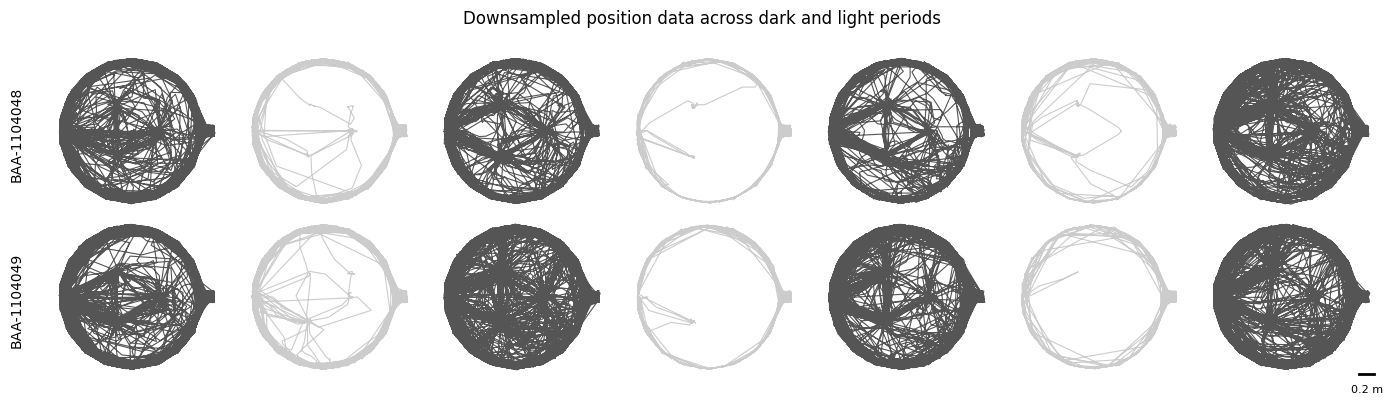

In [13]:
# Setup
subjects = sorted(position_df_downsampled["identity_name"].unique())
n_subj = len(subjects)
n_per = int(position_df_downsampled["light_id"].max())

# Create subplot grid
fig, axes = plt.subplots(
    nrows=n_subj,
    ncols=n_per,
    figsize=(2 * n_per, 2 * n_subj),
    sharex=True,
    sharey=True,
    squeeze=False,
)

for i, subj in enumerate(subjects):
    for j in range(1, n_per + 1):
        ax = axes[i, j - 1]
        sub = position_df_downsampled[
            (position_df_downsampled.identity_name == subj) & (position_df_downsampled.light_id == j)
        ]
        if sub.empty:
            ax.set_axis_off()
            continue
        col = dark_color if sub.is_dark.iloc[0] else light_color
        ax.plot(sub["x"].values, sub["y"].values, color=col, linewidth=0.8, rasterized=True)
        ax.set_aspect("equal", "box")
        ax.axis("off")
        if j == 1:
            ax.text(
                -0.15, 0.5, subj, transform=ax.transAxes, fontsize=10, va="center", ha="right", rotation=90
            )


# Add scale bar to bottom-right subplot
last_ax = axes[-1, -1]
length_px = 0.2 * 100 * cm2px
xmin, xmax = last_ax.get_xlim()
ymin, ymax = last_ax.get_ylim()
x1 = xmax - 0.02 * (xmax - xmin)
x0 = x1 - length_px
y0 = ymin + 0.02 * (ymax - ymin)

last_ax.plot([x0, x1], [y0, y0], "k-", lw=2)
last_ax.text(
    (x0 + x1) / 2,
    y0 - 0.06 * (ymax - ymin),
    "0.2 m",
    va="top",
    ha="center",
    fontsize=8,
    color="k",
)
fig.suptitle("Downsampled position data across dark and light periods")
plt.tight_layout()
plt.show()

## Patch data

For each {term}`Block`, we also compute and store [foraging patch](target-foraging-patch)-related data.
The data includes:
- **patch information** (`block_analysis.BlockAnalysis.Patch`): wheel timestamps, patch rate, and patch offset for each block
- **subject patch data** (`block_analysis.BlockSubjectAnalysis.Patch`): subjects' interactions with patches, including information on their presence in patches (duration, timestamps, RFID detections), pellet consumption (count, timestamps), and wheel movement (distance travelled)
- **subject patch preferences** (`block_analysis.BlockSubjectAnalysis.Preference`): preferences of subjects for different patches

In [4]:
def load_subject_patch_data(
    key: dict[str, str], period_start: str, period_end: str
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """Loads subject patch data for a specified time period.

    Args:
        key (dict): The key to filter the subject patch data.
        period_start (str): The start time for the period.
        period_end (str): The end time for the period.

    Returns:
        tuple: A tuple containing:
            - patch_info (pd.DataFrame): Information about patches.
            - block_subject_patch_data (pd.DataFrame): Data for the specified period.
            - block_subject_patch_pref (pd.DataFrame): Preference data for the specified period.
    """
    patch_info = (
        BlockAnalysis.Patch()
        & key
        & f"block_start >= '{period_start}'"
        & f"block_start <= '{period_end}'"
    ).fetch(
        "block_start",
        "patch_name",
        "patch_rate",
        "patch_offset",
        "wheel_timestamps",
        as_dict=True,
    )

    block_subject_patch_data = (
        BlockSubjectAnalysis.Patch()
        & key
        & f"block_start >= '{period_start}'"
        & f"block_start <= '{period_end}'"
    ).fetch(format="frame")

    block_subject_patch_pref = (
        BlockSubjectAnalysis.Preference()
        & key
        & f"block_start >= '{period_start}'"
        & f"block_start <= '{period_end}'"
    ).fetch(format="frame")

    if patch_info:
        patch_info = pd.DataFrame(patch_info)

    if isinstance(block_subject_patch_data, pd.DataFrame) and not block_subject_patch_data.empty:
        block_subject_patch_data.reset_index(inplace=True)

    if isinstance(block_subject_patch_pref, pd.DataFrame) and not block_subject_patch_pref.empty:
        block_subject_patch_pref.reset_index(inplace=True)

    return patch_info, block_subject_patch_data, block_subject_patch_pref

In [5]:
block_patch_info, block_subject_patch_data, block_subject_patch_pref = load_subject_patch_data(key, start_dt, end_dt)

# Drop NaNs in preference columns
block_subject_patch_pref = block_subject_patch_pref.dropna(subset=["final_preference_by_time", "final_preference_by_wheel"])

# Validate subject count for pre/post-social blocks
if period_name in ["presocial", "postsocial"] and not block_subject_patch_data.empty:
    n_subjects = block_subject_patch_data.groupby("block_start")["subject_name"].nunique()
    if (n_subjects != 1).any():
        warnings.warn(
            f"{exp['name']} {period_name} blocks have >1 subject. Data may need cleaning."
        )

# Ensure timestamp arrays are datetime64[ns]
for col in ["pellet_timestamps", "in_patch_rfid_timestamps", "in_patch_timestamps"]:
    if col in block_subject_patch_data.columns:
        block_subject_patch_data[col] = block_subject_patch_data[col].apply(ensure_ts_arr_datetime)

In [24]:
block_patch_info

,block_start,patch_name,wheel_timestamps,patch_rate,patch_offset
0,2024-02-09 18:19:04.000000,Patch1,"[2024-02-09T18:19:04.000000000, 2024-02-09T18:...",0.0100,75.0
1,2024-02-09 18:19:04.000000,Patch2,"[2024-02-09T18:19:04.000000000, 2024-02-09T18:...",0.0020,75.0
2,2024-02-09 18:19:04.000000,Patch3,"[2024-02-09T18:19:04.000000000, 2024-02-09T18:...",0.0033,75.0
3,2024-02-09 20:07:25.041984,Patch1,"[2024-02-09T20:07:25.060000000, 2024-02-09T20:...",0.0020,75.0
4,2024-02-09 20:07:25.041984,Patch2,"[2024-02-09T20:07:25.060000000, 2024-02-09T20:...",0.0033,75.0
...,...,...,...,...,...
109,2024-02-12 14:31:02.005984,Patch2,"[2024-02-12T14:31:02.020000000, 2024-02-12T14:...",0.0033,75.0
110,2024-02-12 14:31:02.005984,Patch3,"[2024-02-12T14:31:02.020000000, 2024-02-12T14:...",0.0100,75.0
111,2024-02-12 16:53:14.000000,Patch1,"[2024-02-12T16:53:14.000000000, 2024-02-12T16:...",0.0020,75.0
112,2024-02-12 16:53:14.000000,Patch2,"[2024-02-12T16:53:14.000000000, 2024-02-12T16:...",0.0100,75.0


In [13]:
block_subject_patch_data

,experiment_name,block_start,patch_name,subject_name,in_patch_timestamps,in_patch_time,in_patch_rfid_timestamps,pellet_count,pellet_timestamps,patch_threshold,wheel_cumsum_distance_travelled,period
0,social0.2-aeon4,2024-02-09 18:19:04,Patch1,BAA-1104048,"[2024-02-09T18:26:44.600000000, 2024-02-09T18:...",756.60,"[2024-02-09T18:26:45.736672000, 2024-02-09T18:...",39,"[2024-02-09T18:26:50.373504000, 2024-02-09T18:...","[125.10144062824004, 125.98842043772429, 133.9...","[-0.0, 0.004602223261072957, 0.007670372101788...",social
1,social0.2-aeon4,2024-02-09 18:19:04,Patch1,BAA-1104049,"[2024-02-09T18:21:10.200000000, 2024-02-09T18:...",570.18,"[2024-02-09T18:21:11.452832000, 2024-02-09T18:...",26,"[2024-02-09T18:28:57.907488000, 2024-02-09T18:...","[75.07162358109204, 186.27023735234684, 135.82...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",social
2,social0.2-aeon4,2024-02-09 18:19:04,Patch2,BAA-1104048,"[2024-02-09T18:20:10.400000000, 2024-02-09T18:...",123.32,"[2024-02-09T18:20:12.097312000, 2024-02-09T18:...",0,[],[],"[-0.0, -0.004602223261073846, -0.0015340744203...",social
3,social0.2-aeon4,2024-02-09 18:19:04,Patch2,BAA-1104049,"[2024-02-09T18:20:54.600000000, 2024-02-09T18:...",226.80,"[2024-02-09T18:21:30.375328000, 2024-02-09T18:...",3,"[2024-02-09T18:52:14.199488000, 2024-02-09T19:...","[1069.4286592499257, 694.8095229017808, 278.84...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",social
4,social0.2-aeon4,2024-02-09 18:19:04,Patch3,BAA-1104048,"[2024-02-09T18:20:03.940000000, 2024-02-09T18:...",138.78,"[2024-02-09T18:25:59.113504000, 2024-02-09T18:...",1,[2024-02-09T19:30:22.688480000],[331.8480024096391],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",social
...,...,...,...,...,...,...,...,...,...,...,...,...
223,social0.2-aeon4,2024-02-12 16:53:14,Patch1,BAA-1104049,"[2024-02-12T17:01:34.760000000, 2024-02-12T17:...",94.98,"[2024-02-12T17:01:35.372416000, 2024-02-12T17:...",0,[],[],"[-0.0, -0.00920444652214547, -0.00613629768143...",social
224,social0.2-aeon4,2024-02-12 16:53:14,Patch2,BAA-1104048,"[2024-02-12T16:58:52.540000000, 2024-02-12T16:...",627.76,"[2024-02-12T16:58:53.758496000, 2024-02-12T16:...",18,"[2024-02-12T17:01:47.607488000, 2024-02-12T17:...","[128.88388967189582, 98.29740841703715, 138.54...","[-0.0, 0.0030681488407182655, 0.00306814884071...",social
225,social0.2-aeon4,2024-02-12 16:53:14,Patch2,BAA-1104049,"[2024-02-12T16:53:55.360000000, 2024-02-12T16:...",1215.12,"[2024-02-12T16:53:56.698656000, 2024-02-12T16:...",34,"[2024-02-12T16:57:31.338496000, 2024-02-12T16:...","[245.09652119007265, 137.19851472663964, 129.5...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",social
226,social0.2-aeon4,2024-02-12 16:53:14,Patch3,BAA-1104048,"[2024-02-12T16:58:45.920000000, 2024-02-12T16:...",101.68,"[2024-02-12T16:58:47.270432000, 2024-02-12T16:...",0,[],[],"[-0.0, 0.0, -0.006136297681431202, -0.00460222...",social


To visualise wheel distance spun by each subject at each foraging patch, we downsample the raw cumulative traces by computing the absolute difference between consecutive distance values and retaining only those points where the change exceeds 0.5 cm.

In [ ]:
dt_seconds = 0.02 # wheel sampling interval
records = []
# Flatten and downsample
for (subject_name, patch), grp in block_subject_patch_data.groupby(["subject_name", "patch_name"]):
    grp = grp.sort_values("block_start")
    offset = 0.0
    for bs_val, arr in zip(grp.block_start, grp.wheel_cumsum_distance_travelled):
        arr = np.asarray(arr)
        n = arr.size
        offs = (np.arange(n) * dt_seconds * 1e9).astype("timedelta64[ns]")
        times = np.datetime64(bs_val) + offs
        dists = arr + offset
        offset += arr[-1]
        # Downsample: keep points where Δ > 0.5
        diffs = np.abs(np.diff(dists, prepend=dists[0]))
        mask = diffs > 0.5
        mask[0] = True
        for t, d in zip(times[mask], dists[mask]):
            records.append({
                "time": t,
                "distance_m": d / 100,
                "subject": subject_name,
                "patch": patch
            })

# Build long-form DataFrame
flat_df = pd.DataFrame.from_records(records)

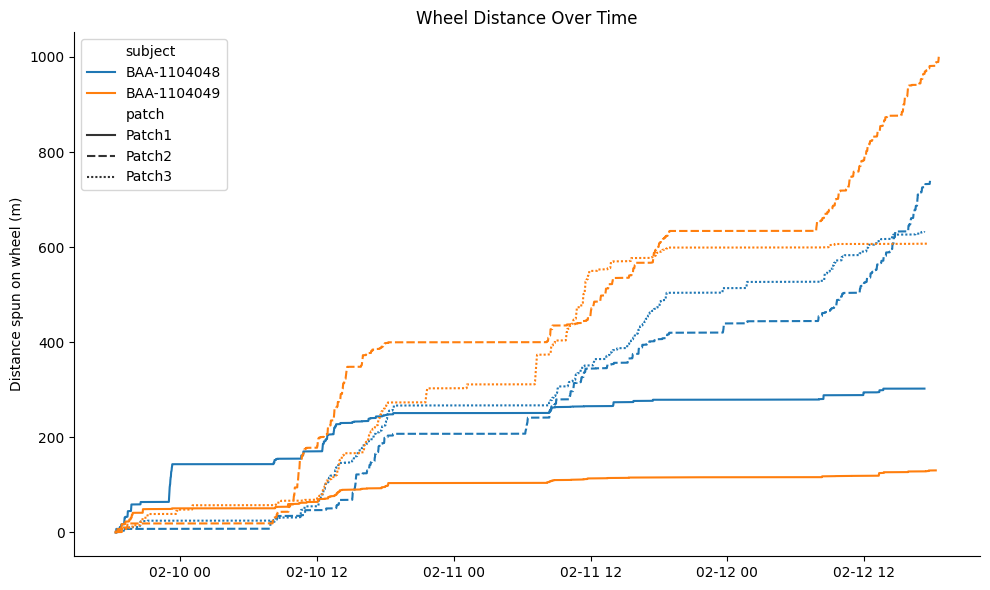

In [8]:
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=flat_df,
    x="time",
    y="distance_m",
    hue="subject",
    style="patch",
    linewidth=1.5
)

plt.ylabel("Distance spun on wheel (m)")
plt.xlabel("")
plt.title("Wheel Distance Over Time")
sns.despine()
plt.tight_layout()
plt.show()

We can also plot the pellet delivery events for each subject.

In [26]:
df = (
    block_subject_patch_data[["subject_name", "patch_name", "pellet_timestamps"]]
    .explode("pellet_timestamps")
    .dropna(subset=["pellet_timestamps"])
    .copy()
)
df["pellet_timestamps"] = pd.to_datetime(df["pellet_timestamps"])
df["patch_idx"] = df["patch_name"].str.extract(r"(\d+)$")
df["patch_idx"] = pd.Categorical(df["patch_idx"], ordered=True, categories=sorted(df["patch_idx"].unique()))


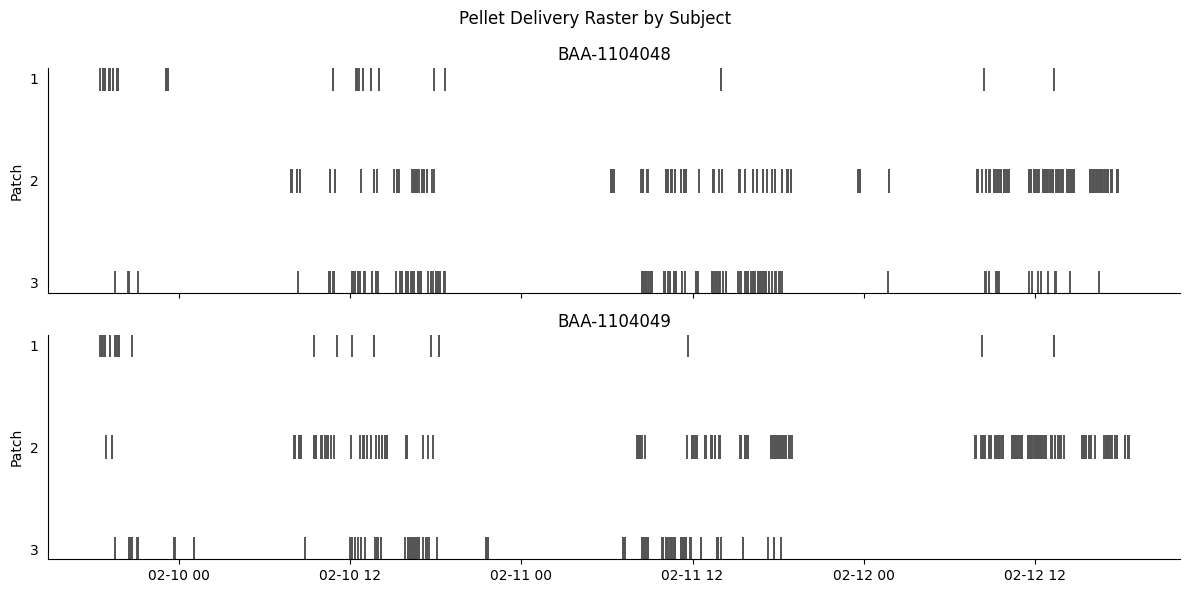

In [34]:
g = sns.FacetGrid(
    df,
    col="subject_name",
    col_wrap=1,
    aspect=4,
    sharex=True,
)
g.map_dataframe(
    sns.scatterplot,
    x="pellet_timestamps",
    y="patch_idx",
    marker="|",
    color=dark_color,
    s=300,
)
for ax in g.axes.flat:
    ax.set_ylabel("Patch")
    ax.set_xlabel("")
    ax.grid(False)
    ax.tick_params(axis="y", left=False)
    ax.set_title(ax.get_title().replace("subject_name = ", ""))
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle("Pellet Delivery Raster by Subject")
plt.tight_layout()
plt.show()

In [14]:
block_subject_patch_pref

,experiment_name,block_start,patch_name,subject_name,cumulative_preference_by_wheel,cumulative_preference_by_time,running_preference_by_time,running_preference_by_wheel,final_preference_by_wheel,final_preference_by_time,period
0,social0.2-aeon4,2024-02-09 18:19:04,Patch1,BAA-1104048,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.758947,0.742711,social
1,social0.2-aeon4,2024-02-09 18:19:04,Patch1,BAA-1104049,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.548170,0.574604,social
2,social0.2-aeon4,2024-02-09 18:19:04,Patch2,BAA-1104048,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.096201,0.121056,social
3,social0.2-aeon4,2024-02-09 18:19:04,Patch2,BAA-1104049,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.251308,0.228560,social
4,social0.2-aeon4,2024-02-09 18:19:04,Patch3,BAA-1104048,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.144852,0.136232,social
...,...,...,...,...,...,...,...,...,...,...,...
223,social0.2-aeon4,2024-02-12 16:53:14,Patch1,BAA-1104049,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.038067,0.069930,social
224,social0.2-aeon4,2024-02-12 16:53:14,Patch2,BAA-1104048,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.831808,0.778163,social
225,social0.2-aeon4,2024-02-12 16:53:14,Patch2,BAA-1104049,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.955588,0.894642,social
226,social0.2-aeon4,2024-02-12 16:53:14,Patch3,BAA-1104048,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.162096,0.126041,social


## Foraging bouts

Based on `block_analysis.BlockSubjectAnalysis.Patch`, foraging bouts—defined as time intervals in which a subject initiates at least 3 pellet deliveries and rotates the patch wheel by at least one full turn within a 60-second period—are identified and stored in the `block_analysis.BlockForaging.Bout` table.

We will now retrieve the foraging bouts for each subject across all {term}`blocks <Block>` from this table.

In [33]:
def load_foraging_bouts(
    key: dict[str, str], period_start: str, period_end: str
) -> pd.DataFrame:
    """Loads foraging bout data for blocks falling within a specified time period.

    Args:
        key (dict): Key to identify experiment data (e.g., {"experiment_name": "Exp1"}).
        period_start (str): Start datetime of the time period (format: '%Y-%m-%d %H:%M:%S').
        period_end (str): End datetime of the time period (format: '%Y-%m-%d %H:%M:%S').

    Returns:
        pd.DataFrame: Dataframe of foraging bouts for all matching blocks.
                      Returns an empty dataframe with predefined columns if no data found.
    """
    # Fetch bouts within the specified period
    bouts_dict = (Block * BlockForaging.Bout & key & f"block_start >= '{period_start}'" & f"block_end <= '{period_end}'").fetch("subject_name", "bout_start", "bout_end", "pellet_count", "cum_wheel_dist", as_dict=True)
    if bouts_dict:
        return pd.DataFrame(bouts_dict).sort_values(["bout_start"])
    else:
        return pd.DataFrame(
            columns=["subject_name", "bout_start", "bout_end", "pellet_count", "cum_wheel_dist"]
        )

# Load foraging bouts
foraging_df = load_foraging_bouts(key, start_dt, end_dt)

In [34]:
foraging_df

,subject_name,bout_start,bout_end,pellet_count,cum_wheel_dist
0,BAA-1104048,2024-02-09 18:39:17.180,2024-02-09 18:42:14.880,7,983.174
1,BAA-1104048,2024-02-09 18:48:14.880,2024-02-09 18:50:11.720,3,512.637
5,BAA-1104049,2024-02-09 18:50:01.360,2024-02-09 18:54:16.560,8,1899.180
2,BAA-1104048,2024-02-09 19:03:35.840,2024-02-09 19:07:51.260,11,1979.470
6,BAA-1104049,2024-02-09 19:09:47.100,2024-02-09 19:11:58.200,4,510.634
...,...,...,...,...,...
151,BAA-1104048,2024-02-12 16:03:42.420,2024-02-12 16:08:18.900,7,1275.080
152,BAA-1104048,2024-02-12 16:17:47.480,2024-02-12 16:21:39.080,4,1078.850
153,BAA-1104048,2024-02-12 16:24:17.660,2024-02-12 16:26:56.160,3,680.643
154,BAA-1104048,2024-02-12 16:30:04.740,2024-02-12 16:33:20.300,3,981.212


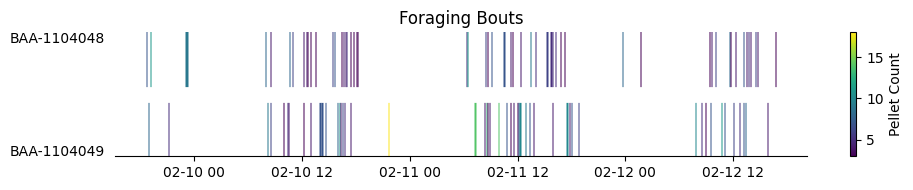

In [78]:
subjects = sorted(foraging_df["subject_name"].unique())[::-1]
cmap = mpl.colormaps["viridis"]  # or "plasma", "magma", "Greys"
norm = mcolors.Normalize(vmin=foraging_df["pellet_count"].min(), vmax=foraging_df["pellet_count"].max())
fig, ax = plt.subplots(figsize=(10, len(subjects)))
for i, subj in enumerate(subjects):
    bouts = foraging_df[foraging_df["subject_name"] == subj]
    for _, row in bouts.iterrows():
        color = cmap(norm(row["pellet_count"]))
        ax.hlines(
            y=i,
            xmin=row["bout_start"],
            xmax=row["bout_end"],
            color=color,
            linewidth=70
            )
ax.set_yticks(range(len(subjects)))
ax.set_yticklabels(subjects)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Foraging Bouts")
sns.despine(left=True)
ax.tick_params(axis="y", which="both", left=False)
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
fig.colorbar(sm, ax=ax, label="Pellet Count")
plt.tight_layout()
plt.show()

## RFID data

In this experiment, each subject is implanted with a miniature RFID microchip.
RFID readers are positioned at the [foraging patches](target-foraging-patch), [nest](target-nest), and [gate](target-habitat).

We will fetch the RFID detection data at each reader across all {term}`chunks <Acquisition Chunk>` occurring within the first 3 days of the social period.

In [66]:
def load_rfid_events(
    key: dict[str, str], period_start: str, period_end: str
) -> pd.DataFrame:
    """Loads RFID events data for chunks falling within a specified time period.

    Args:
        key (dict): Key to identify experiment data (e.g., {"experiment_name": "Exp1"}).
        period_start (str): Start datetime of the time period (format: '%Y-%m-%d %H:%M:%S').
        period_end (str): End datetime of the time period (format: '%Y-%m-%d %H:%M:%S').

    Returns:
        pd.DataFrame: DataFrame containing RFID events for the specified period.
                      Returns an empty dataframe with predefined columns if no data found.
    """
    # Fetch RFID events within the specified period
    rfid_events_df = (
        streams.RfidReader * streams.RfidReaderRfidEvents
        & key
        & f'chunk_start >= "{period_start}"'
        & f'chunk_start <= "{period_end}"'
    ).fetch(format="frame")

    if rfid_events_df.empty or not isinstance(rfid_events_df, pd.DataFrame):
        # Return empty DataFrame with expected columns if no data found
        return pd.DataFrame(
            columns=[
                "experiment_name",
                "chunk_start",
                "rfid_reader_name",
                "sample_count",
                "timestamps",
                "rfid",
            ]
        )

    # Get subject details for RFID mapping
    subject_detail = subject.SubjectDetail.fetch(format="frame")
    subject_detail.reset_index(inplace=True)

    # Create mapping from RFID to subject ID
    rfid_to_lab_id = dict(zip(subject_detail["lab_id"], subject_detail["subject"]))

    rfid_events_df["rfid"] = [
        [rfid_to_lab_id.get(str(rfid)) for rfid in rfid_array]
        for rfid_array in rfid_events_df["rfid"]
    ]

    # Extract experiment_name and chunk_start from the index before resetting
    rfid_events_df["experiment_name"] = [idx[0] for idx in rfid_events_df.index]
    rfid_events_df["chunk_start"] = [
        idx[3] for idx in rfid_events_df.index
    ]  # Assuming chunk_start is at index 3

    # Reset the index and drop the index column
    rfid_events_df = rfid_events_df.reset_index(drop=True)

    # Reorder columns to put experiment_name first and chunk_start second
    cols = ["experiment_name", "chunk_start"] + [
        col
        for col in rfid_events_df.columns
        if col not in ["experiment_name", "chunk_start"]
    ]
    rfid_events_df = rfid_events_df[cols]

    return rfid_events_df

# Load RFID data
rfid_df = load_rfid_events(key, start_dt, end_dt)
rfid_df = rfid_df.explode(["timestamps", "rfid"]).set_index("timestamps").sort_index()
rfid_df = rfid_df[~rfid_df.index.isna()]
rfid_df["rfid_reader_name"] = pd.Categorical(rfid_df["rfid_reader_name"], ordered=True, categories=sorted(rfid_df["rfid_reader_name"].unique()))

In [73]:
rfid_df

,experiment_name,chunk_start,rfid_reader_name,sample_count,rfid
timestamps,,,,,
2024-02-09 17:00:00.483007908,social0.2-aeon4,2024-02-09 17:00:00,Patch1Rfid,844,BAA-1104048
2024-02-09 17:00:14.564960003,social0.2-aeon4,2024-02-09 17:00:00,NestRfid2,85,BAA-1104049
2024-02-09 17:00:15.526688099,social0.2-aeon4,2024-02-09 17:00:00,GateRfid,926,BAA-1104048
2024-02-09 17:00:34.330624104,social0.2-aeon4,2024-02-09 17:00:00,NestRfid1,163,BAA-1104048
2024-02-09 17:00:40.345920086,social0.2-aeon4,2024-02-09 17:00:00,GateRfid,926,BAA-1104048
...,...,...,...,...,...
2024-02-12 17:48:49.640480042,social0.2-aeon4,2024-02-12 17:00:00,GateRfid,1990,BAA-1104048
2024-02-12 17:48:50.048992157,social0.2-aeon4,2024-02-12 17:00:00,GateRfid,1990,BAA-1104048
2024-02-12 17:48:50.416895866,social0.2-aeon4,2024-02-12 17:00:00,GateRfid,1990,BAA-1104048


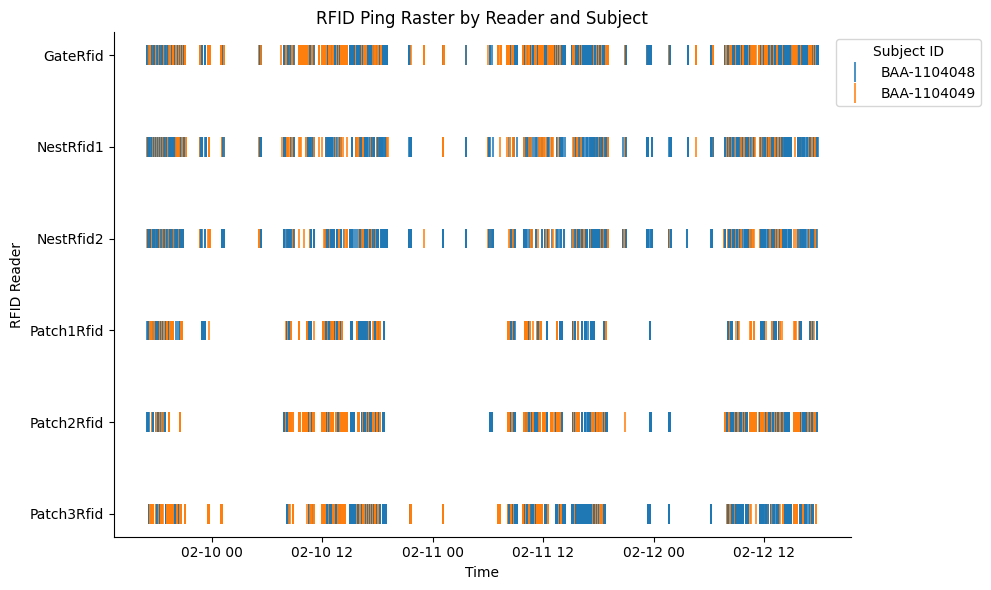

In [83]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=rfid_df,
    x="timestamps",
    y="rfid_reader_name",
    hue="rfid",
    marker="|",         # vertical tick
    s=200,              # marker size
)
plt.xlabel("Time")
plt.ylabel("RFID Reader")
plt.title("RFID Ping Raster by Reader and Subject")
plt.legend(title="Subject ID", bbox_to_anchor=(0.97, 1), loc="upper left")
sns.despine()
plt.tight_layout()
plt.show()


## Weight data

A weighing scale integrated into the [nest](target-nest) records the weight data for each subject whenever a subject is alone in the nest. 

Here we will fetch the weight data for each subject across all {term}`chunks <Acquisition Chunk>` occurring within the first 3 days of the social period.

In [44]:
def load_weight_data(
    key: dict[str, str], period_start: str, period_end: str
) -> pd.DataFrame:
    """Loads weight data for a specified time period.

    Args:
        key (dict): Key to identify experiment data (e.g., {"experiment_name": "Exp1"}).
        period_start (str): Start datetime of the time period (format: '%Y-%m-%d %H:%M:%S').
        period_end (str): End datetime of the time period (format: '%Y-%m-%d %H:%M:%S').

    Returns:
        pd.DataFrame: Weight data for the specified period.
                      Returns an empty dataframe if no data found.
    """
    try:
        weight_df = (
            acquisition.Environment.SubjectWeight
            & key
            & f"chunk_start >= '{period_start}'"
            & f"chunk_start <= '{period_end}'"
        ).proj("timestamps", "weight", "subject_id").fetch(format="frame")
        return weight_df if not weight_df.empty and isinstance(weight_df, pd.DataFrame) else pd.DataFrame()
    except Exception as e:
        print(
            f"Error loading weight data for {key} from {period_start} to {period_end}: {e}"
        )
        return pd.DataFrame()


weight_df = load_weight_data(key, start_dt, end_dt)
weight_df = (
    weight_df
    .explode(["timestamps", "weight", "subject_id"])
    .set_index("timestamps")
    .sort_index().dropna()
)

In [53]:
weight_df

,weight,subject_id
timestamps,,
2024-02-09 17:12:29.800000191,23.522316,BAA-1104049
2024-02-09 17:12:29.900000095,23.522316,BAA-1104049
2024-02-09 17:12:29.960000038,23.522316,BAA-1104049
2024-02-09 17:12:30.039999962,23.522316,BAA-1104049
2024-02-09 17:12:30.139999866,23.522316,BAA-1104049
...,...,...
2024-02-12 17:41:37.019999981,24.553659,BAA-1104048
2024-02-12 17:41:37.099999905,24.553659,BAA-1104048
2024-02-12 17:41:37.199999809,24.553659,BAA-1104048


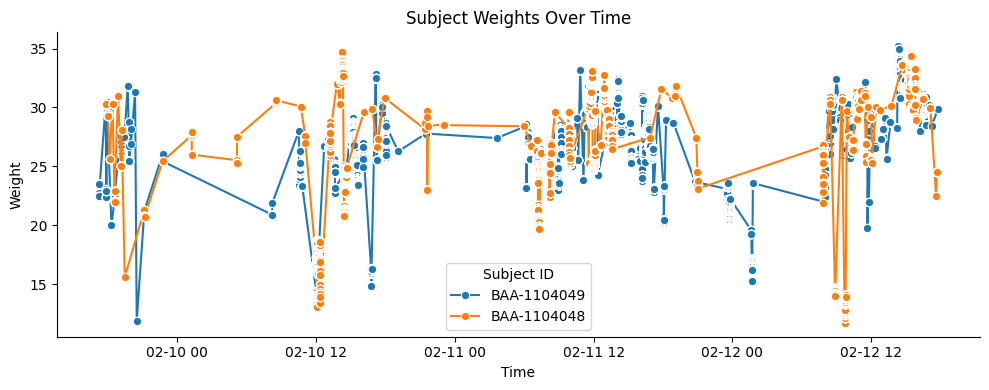

In [56]:
plt.figure(figsize=(10, 4))
sns.lineplot(
    data=df,
    x="timestamps",
    y="weight",
    hue="subject_id",
    marker="o",
    linewidth=1.5,
    markers=True,
)
plt.title("Subject Weights Over Time")
plt.xlabel("Time")
plt.ylabel("Weight")
plt.legend(title="Subject ID")
sns.despine()
plt.tight_layout()
plt.show()
